<a href="https://colab.research.google.com/github/Mr-Grag-Universe/NLA_project/blob/main/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# ref

In [ ]:
def random_svd(X, r):
    P = np.random.randn(X.shape[1], r)
    Z = X @ P
    Q, R = np.linalg.qr(Z, mode="reduced")
    Y = Q.conj().T @ X
    U_y, S, V = np.linalg.svd(Y, full_matrices=False)
    U = Q @ U_y
    return U, S, V

In [ ]:
def super_random_svd(X, r=None, eps=None, power_iter=None):
    m, n = X.shape
    if r is None:
        assert eps is not None, "not None eps must be passed with r=None"
        Omega = np.random.randn(n, 1)
        # я не вполне понимаю, как это делается

    P = np.random.randn(n, r)
    Z = X @ P
    if power_iter:
        for i in range(power_iter):
            Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z, mode="reduced")
    Y = Q.conj().T @ X
    U_y, S, V = np.linalg.svd(Y, full_matrices=False)
    U = Q @ U_y

    return U, S, V

# main

In [ ]:
def randomized_range_finder_v1(X, l, power_iter=1):
    Omega = np.random.normal(size=(X.shape[1], l))

    for i in range(power_iter):
        Omega = np.dot(X, Omega)
        Omega = np.dot(X.T, Omega)

    Q, _ = np.linalg.qr(np.dot(X, Omega))

    return Q

In [ ]:
def randomized_svd_v1(A, l, power_iter=3):
    Q = randomized_range_finder_v1(A, l=l, power_iter=power_iter)

    Y = np.dot(Q.conj().T, A)
    Uhat, s, Vt = np.linalg.svd(Y, full_matrices=False)
    del Y

    U = np.dot(Q, Uhat)

    # max_abs_cols = np.argmax(np.abs(U), axis=0)
    # signs = np.sign(U[max_abs_cols, range(U.shape[1])])
    # U *= signs
    # Vt *= signs[:, np.newaxis]

    return U, s, Vt

In [ ]:
X = Image.open("cat.png")
X = np.array(X, dtype=np.uint8)[:, :, 0]
X.shape

(675, 900)

In [ ]:
u, s, vt = randomized_svd_v1(X, 30, 5)

(675, 30)


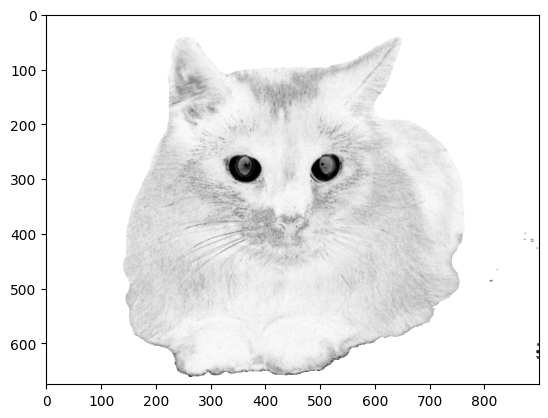

In [ ]:
plt.imshow(X, cmap=plt.cm.gray_r)

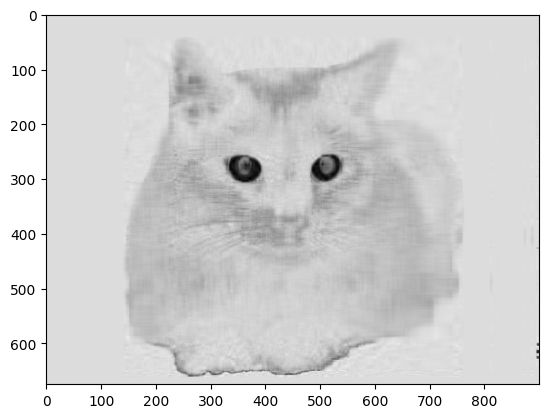

In [ ]:
plt.imshow((u @ np.diagflat(s) @ vt), cmap=plt.cm.gray_r)

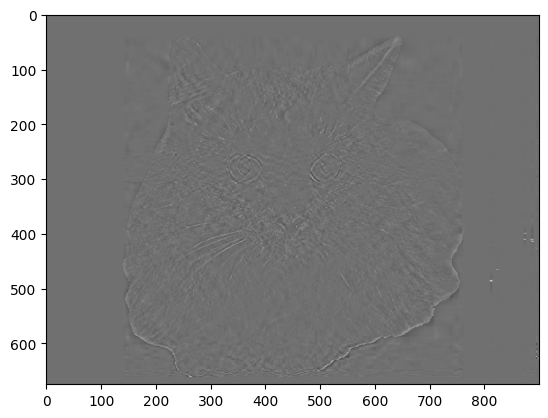

In [ ]:
plt.imshow((u @ np.diagflat(s) @ vt)-X, cmap=plt.cm.gray_r)

In [ ]:
def randomized_range_finder_v2(X, max_iter):
    l = 0
    error = np.inf
    while(True):
        l += 1
        omega_i = np.random.normal(size=(X.shape[1], 1))

        y_i = np.dot(X, omega_i)
        if l == 1:
            q_i = y_i
            q_i /= np.linalg.norm(q_i)
            Q = q_i.copy()
        else:
            QQ = Q[:, :l] @ Q[:, :l].conj().T
            q_i = (np.eye(QQ.shape[0]) - QQ) @ y_i
            q_i /= np.linalg.norm(q_i)
            Q = np.concatenate([Q, q_i], axis=1)

        prev_error = error
        error = np.linalg.norm(np.eye(Q.shape[0]) - Q @ Q.conj().T)
        if prev_error < error:
            break
        if l > max_iter:
            break

    return Q[:, :l]

In [ ]:
def randomized_svd_v2(A, max_iter=1000):
    Q = randomized_range_finder_v2(A, max_iter=max_iter)

    Y = np.dot(Q.conj().T, A)
    Uhat, s, Vt = np.linalg.svd(Y, full_matrices=False)
    del Y

    U = np.dot(Q, Uhat)

    return U, s, Vt

In [ ]:
u, s, vt = randomized_svd_v2(X)

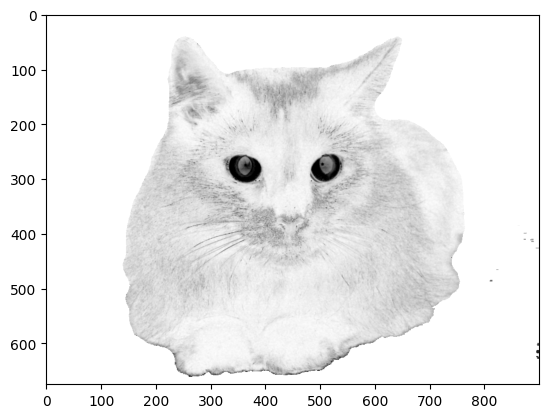

In [ ]:
plt.imshow((u @ np.diagflat(s) @ vt), cmap=plt.cm.gray_r)

In [ ]:
s.shape

(622,)

# QR

In [ ]:
def qr_householder(A):
    n, m = A.shape

    V = np.zeros_like(A)
    R = np.array(A)
    for k in range(n):
        V[k:, k] = R[k:, k].copy()
        V[k, k] += np.sign(V[k, k]) * np.linalg.norm(V[k:, k], 2)
        V[k:, k] /= np.linalg.norm(V[k:, k], 2)
        R[k:, k:] -= 2 * np.outer(V[k:, k], np.dot(V[k:, k], R[k:, k:]))
    R = np.triu(R[:n, :n])

    Q = np.eye(m, n)
    for k in range((n - 1), -1, -1):
        Q[k:, k:] -= np.dot((2 * (np.outer(V[k:, k], V[k:, k]))), Q[k:, k:])

    return Q, R

In [ ]:
v = np.random.randn(500, 500)

In [ ]:
q, r = qr_householder(v)

In [ ]:
%timeit qr_householder(v)

39.3 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit np.linalg.qr(v)

1.38 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
q_true, r_true = np.linalg.qr(v)

In [ ]:
np.allclose(q, q_true), np.allclose(r, r_true)

(False, False)

In [ ]:
q @ r

array([[-1.71706228e-01,  8.72083350e-01, -2.64972183e-01, ...,
         2.31336130e-01, -2.72454269e+00,  8.61478722e-01],
       [-1.42091995e+00, -7.64979552e-01,  1.06350182e+00, ...,
        -7.65567580e-01, -4.74508671e-01,  2.67044149e-01],
       [ 6.56469918e-01,  1.06670419e+00,  6.17254013e-01, ...,
        -1.83457029e+00,  3.66624087e-01, -7.13319263e-01],
       ...,
       [ 7.69603460e-01, -6.93300606e-01, -1.54290298e-01, ...,
        -3.22914838e+00, -1.20560749e+00,  8.99829188e-01],
       [-1.91101453e-03,  5.94680546e-01, -4.57578520e-01, ...,
        -1.51153830e+00, -1.24336473e+00, -1.13763759e-02],
       [ 6.82954106e-01, -7.69948529e-01,  1.01267331e+00, ...,
        -1.78207069e+00, -1.58345152e+00, -2.78091263e-01]])

In [ ]:
v

array([[-1.71706228e-01,  8.72083350e-01, -2.64972183e-01, ...,
         2.31336130e-01, -2.72454269e+00,  8.61478722e-01],
       [-1.42091995e+00, -7.64979552e-01,  1.06350182e+00, ...,
        -7.65567580e-01, -4.74508671e-01,  2.67044149e-01],
       [ 6.56469918e-01,  1.06670419e+00,  6.17254013e-01, ...,
        -1.83457029e+00,  3.66624087e-01, -7.13319263e-01],
       ...,
       [ 7.69603460e-01, -6.93300606e-01, -1.54290298e-01, ...,
        -3.22914838e+00, -1.20560749e+00,  8.99829188e-01],
       [-1.91101453e-03,  5.94680546e-01, -4.57578520e-01, ...,
        -1.51153830e+00, -1.24336473e+00, -1.13763759e-02],
       [ 6.82954106e-01, -7.69948529e-01,  1.01267331e+00, ...,
        -1.78207069e+00, -1.58345152e+00, -2.78091263e-01]])

In [ ]:
q_true @ r_true

array([[-1.71706228e-01,  8.72083350e-01, -2.64972183e-01, ...,
         2.31336130e-01, -2.72454269e+00,  8.61478722e-01],
       [-1.42091995e+00, -7.64979552e-01,  1.06350182e+00, ...,
        -7.65567580e-01, -4.74508671e-01,  2.67044149e-01],
       [ 6.56469918e-01,  1.06670419e+00,  6.17254013e-01, ...,
        -1.83457029e+00,  3.66624087e-01, -7.13319263e-01],
       ...,
       [ 7.69603460e-01, -6.93300606e-01, -1.54290298e-01, ...,
        -3.22914838e+00, -1.20560749e+00,  8.99829188e-01],
       [-1.91101453e-03,  5.94680546e-01, -4.57578520e-01, ...,
        -1.51153830e+00, -1.24336473e+00, -1.13763759e-02],
       [ 6.82954106e-01, -7.69948529e-01,  1.01267331e+00, ...,
        -1.78207069e+00, -1.58345152e+00, -2.78091263e-01]])

In [ ]:
np.allclose(q @ r, q_true @ r_true)

True

In [ ]:
np.linalg.norm(q @ q.T - np.eye(150))

1.4234037219377647e-14

In [ ]:
np.linalg.norm(q_true @ q_true.T - np.eye(150))

1.1086053625681861e-14

In [ ]:
def implicit_qr(A, b):
    # QR-разложение матрицы A
    A = np.array(A)
    Q, R = np.linalg.qr(A)

    x = np.zeros(len(A[0]))
    for i in range(len(x)):
        # Вычисление i-й компоненты решения
        x[i] = np.dot(R.T[i,:], b) / R[i, i]

        # Обнуление нижних строк R после i-ой итерации
        for j in range(i+1, len(x)):
            R[j,i:] = 0

    return x

In [ ]:
def pure_qr_algo(A, max_iter=100):
    Ak = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n)

    for k in range(max_iter):
        Q, R = qr_householder(Ak)
        Ak = R @ Q
        QQ = QQ @ Q

    return Ak, QQ

In [ ]:
ak, qq = pure_qr_algo(v)

In [ ]:
ak

array([[ 1.60763925e+00,  1.01023903e+00,  5.53843891e-01,
        -6.35789774e-01],
       [-8.13930097e-02,  1.66421132e+00,  1.25670370e+00,
        -2.42043599e-01],
       [-1.54572705e-15,  3.15362440e-14, -1.21616087e+00,
        -1.26349982e+00],
       [-5.38884679e-16, -1.26395019e-15,  1.09177445e+00,
        -1.83278383e-03]])

# std SVD

In [ ]:
import itertools as it

EPSILON = np.finfo(float).eps
NEPS = 10.0 * EPSILON # via Gu & Eisenstat

def solve_secular_oneroot(d, z, i):
    # translated and modified from:  Arbenz, Peter. see citation below.
    # there are no "l" (ells) in the following code, they are all "1" (ones)
    n = d.size; d_i = d[i]; z = z*z

    if i < n - 1:
        d_ip1   = d[i+1]
        lambda_ = (d_i + d_ip1) / 2.0
    else:
        adder = max(np.linalg.norm(z)**2, 1.0) # protect against small norm
        d_ip1   = d[-1] + adder
        lambda_ = d_ip1

    left_idx, right_idx = slice(0,i+1), slice(i+1, None)
    left_z, right_z = z[left_idx], z[right_idx]

    denoms = d - lambda_    # PN: this makes a new vector
    psi1 = np.sum( left_z**2 / denoms[ left_idx])
    psi2 = np.sum(right_z**2 / denoms[right_idx])

    # determine whether soln is closer to right or left pole
    # (remember, we are currently at lambda == midpt)
    psi_sum = 1.0 + psi1 + psi2
    left_half = psi_sum > 0.0
    active_d = d_i if left_half else d_ip1

    # shift poles (so one of them is zero), initial guess, and d_i,d_ip1
    d = d - active_d
    lambda_ = lambda_ - active_d

    if left_half:
        d_i, d_ip1 = 0.0, d_ip1-d_i
    else:
        d_i, d_ip1 = d_i-d_ip1, 0.0

    stop_cond = NEPS * n * (1.0 + np.abs(psi1) + np.abs(psi2))
    itct = 0
    while (np.abs(psi_sum) > stop_cond and itct < 10):
        itct += 1
        denoms = d - lambda_

        psi1, psi1_p = (np.sum(left_z / denoms[ left_idx]),
                        np.sum(left_z / denoms[ left_idx]**2))
        psi2, psi2_p = (np.sum(right_z / denoms[right_idx]),
                        np.sum(right_z / denoms[right_idx]**2))
        psi_sum = 1.0 + psi1 + psi2


        # D is \Delta : recall, we've shifted d_i, d_ip1 (line 36 above)
        if left_half:
            D_i, D_ip1 = -lambda_, d_ip1 - lambda_
        else:
            D_i, D_ip1 = d_i - lambda_, -lambda_

        #a \eta^2 + b \eta + c = 0
        a = psi_sum - (D_i * psi1_p) - (D_ip1 * psi2_p)
        b = - (D_i + D_ip1) * psi_sum + (D_i * D_ip1 * (psi1_p + psi2_p))
        c = D_i * D_ip1 * psi_sum

        root = np.sqrt(b**2 - 4*a*c)
        eta = (2.0 * c) / (-b + root) if b < 0.0 else (-b - root)/(2.0*a)
        lambda_ = lambda_ + eta

        stop_cond = NEPS * n * (1.0 + np.abs(psi1) + np.abs(psi2))

    d_m_lambda = d - lambda_      # (both shifted) - this will be discussed next post
    lambda_ = lambda_ + active_d
    return lambda_, d_m_lambda

In [ ]:
def unified(d, z):
    N = z.size
    lambdas, d_m_lambda = np.empty(N), np.empty((N,N))
    for k in range(N):
        lambdas[k], d_m_lambda[:,k] = solve_secular_oneroot(d, z, k)

    T = np.empty(N)
    for k in range(N):
        numers, denoms = d_m_lambda[k], d[k] - d
        lower_prod = np.prod(numers[:k] / denoms[:k])
        upper_prod = np.prod(numers[k:-1] / denoms[k+1:])
        term = lower_prod * upper_prod * numers[-1]
        T[k] = np.abs(term)

    np.sqrt(T, out=T)
    with np.errstate(invalid='ignore', divide='warn'):
        Q = T.reshape(N,1) / d_m_lambda
        Q[np.logical_or(np.isnan(Q), np.isinf(Q))] = 1.0

    return lambdas, Q

def outer_eigval_eigvec(d, z):
    if z.size == 1:
        return z**2, np.ones((1,1))

    lambdas, Q = unified(d,z)
    Q /= np.linalg.norm(Q, axis=0)

    return lambdas, Q

def outer_singval_singvec(d_sq, z):
    if z.size == 1:
        return np.ones((1,1)), z, np.ones((1,1))

    omega_sq, U = unified(d_sq,z)
    U *= np.sign(z).reshape(-1,1)
    V = U * np.sqrt(d_sq).reshape(-1,1)
    V[0,:] = -1.0

    U /= np.linalg.norm(U, axis=0)
    V /= np.linalg.norm(V, axis=0)

    return U, np.sqrt(omega_sq), V

In [ ]:
from scipy.sparse import diags
import numpy as np

n = 10
k = [np.ones(n-1),-2*np.ones(n),np.ones(n-1)]
offset = [-1,0,1]
A = diags(k,offset).toarray()

In [ ]:
A

array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

In [ ]:
D = np.random.randn(10)
z = np.random.randn(10)

In [ ]:
print(D)
print(z@z)

[ 0.07599829  0.04408946 -0.97547766 -0.46011241  1.51196226 -0.91361977
  1.98208076  0.13832331 -0.72790808 -0.59265777]
21.766695346502427


In [ ]:
def test_sv(d,z):
    M = np.diag(d)
    M[:,0] = z

    expected = np.linalg.svd(M)
    actual   = outer_singval_singvec(d**2,z)

    return (*expected, *actual)

u_true, s_true, v_ture, u_ac, s_ac, v_ac = test_sv(D, z)

In [ ]:
u_true @ np.diag(s_true) @ v_ture

array([[-8.54565256e-02, -4.92516539e-17, -9.81200563e-17,
        -5.17510808e-17,  1.15328079e-16, -3.64995751e-17,
         1.77482876e-16,  8.08840394e-17, -1.18786086e-17,
         1.12097682e-16],
       [-5.63482528e-01,  4.40894622e-02,  3.72848413e-17,
        -8.70860071e-18,  9.28676048e-16, -1.20720785e-16,
        -1.94021954e-16, -4.75843568e-17, -6.40225280e-17,
         1.10567442e-16],
       [ 1.31354990e+00,  1.93125744e-16, -9.75477663e-01,
        -8.19848667e-17, -3.47988057e-15,  2.05884288e-16,
         1.53268419e-15,  1.76301809e-16,  6.36300794e-17,
         2.21922171e-16],
       [-1.68213045e+00,  1.47756857e-16, -3.74527876e-16,
        -4.60112412e-01,  3.23937287e-15,  5.08382611e-16,
        -1.13675005e-15,  2.00948266e-16, -3.72035880e-16,
        -1.64987353e-16],
       [-1.12201937e+00, -2.66253265e-17,  2.08263531e-16,
        -2.93054483e-16,  1.51196226e+00,  1.61403074e-16,
        -1.26553104e-15, -1.03300948e-17, -5.62256991e-18,
        -9.

In [ ]:
M = np.diag(D)
M[:,0] = z

In [ ]:
np.linalg.norm(M - u_true @ np.diag(s_true) @ v_ture)

1.2830518207180547e-14

In [ ]:
np.linalg.norm(M - u_ac @ np.diag(s_ac) @ v_ac.T)

10.049914871544456

In [ ]:
np.linalg.norm(u_true - u_ac)

4.659044651310786

In [ ]:
np.linalg.norm(s_true - s_ac)

7.1590211010273554

In [ ]:
np.linalg.norm(v_ture - v_ac)

4.699083533667645

In [ ]:
u_ac @ np.diag(s_ac) @ v_ac.T

array([[-1.21534953e+00,  3.01258018e-01, -3.27377213e-01,
         8.89175753e-01,  1.48832833e-01, -2.34070149e-01,
        -2.01719888e-01, -1.25371428e+00, -4.41919502e-02,
         2.49107647e-01],
       [-3.62660993e+00,  1.07118175e+00, -9.76139831e-01,
         2.63746592e+00,  4.44206377e-01, -6.98957050e-01,
        -5.99245785e-01, -3.57918529e+00, -1.30364485e-01,
         7.41053191e-01],
       [ 1.43980939e-01, -4.41193908e-02,  1.24254193e-01,
        -8.28330032e-02, -1.28351524e-02,  1.23321481e-01,
         6.50699535e-02,  1.48069680e-01, -1.48129607e-02,
        -2.44165277e-02],
       [-6.90511920e-01,  2.52730531e-01, -1.75613051e-01,
         6.97582750e-01,  7.90070078e-02, -1.01687437e-01,
        -1.54680380e-01, -8.62398969e-01, -5.51646020e-02,
         1.27098730e-01],
       [-5.84419609e-02,  1.29532468e-02, -8.28089744e-03,
         2.40429976e-02,  1.12132570e-01, -1.17930712e-02,
        -6.62045139e-02, -4.33328738e-02,  2.04470531e-03,
         6.

In [ ]:
M

array([[-0.08545653,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.56348253,  0.04408946,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.3135499 ,  0.        , -0.97547766,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.68213045,  0.        ,  0.        , -0.46011241,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-1.12201937,  0.        ,  0.        ,  0.        ,  1.51196226,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.39683083,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.91361977,  0.        ,  0.        ,  0.        ,  0.        ],
       [-3.71774382,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.98208076,  0.        

In [ ]:
def power_method(A, x0, num_iter):
    x0= x0 / np.linalg.norm(x0)
    x = A @ x0

    res = np.zeros(num_iter+1)
    res[0] = np.linalg.norm(A @ x0 - np.dot(A @ x0, x0)*x0)

    for i in range(1, num_iter):
        x = A @ x
        x = x / np.linalg.norm(x)
        l = np.vdot(A @ x, x)
        res[i] = np.linalg.norm(A @ x - l*x)

    return x, l, res

In [ ]:
def svdj(X, iters=4, eps=1e-8):
	m, n = np.shape(X)
	r_c = [[r, c] for r in range(n-1) for c in range (r+1, n)]

	v = np.eye(n)  # V = F(eye(N));

	on = np.sum(np.sum(np.abs(X)**2))/n  # On = 0; for c = A, On = On + sum(abs(c).^2); end; On = On ./ N;

	for i in range(iters):
		cnt = 0
		for r, c in r_c:
			a1 = X[:, r]
			a2 = X[:, c]

			b_rr = sum(abs(a1)**2)          # b_rr = sum(abs(A(:,r)).^2);
			b_cc = sum(abs(a2)**2)          # b_cc = sum(abs(A(:,c)).^2);
			b_rc = np.dot(a1.conj().T , a2) # b_rc = A(:,r)' * A(:,c);
			m_b_rc = np.abs(b_rc);             # m = abs(b_rc);

			if not m_b_rc:
				continue

			tau_m = (b_cc - b_rr) / (2 * m_b_rc)   # tau = (b_cc - b_rr) / (2 * m);

			if not tau_m:
				continue

			cnt += 1
			t = np.sign(tau_m) / (abs(tau_m) + np.sqrt(1.0 + tau_m**2))  # t = sign(tau) ./ (abs(tau) + sqrt(1 + tau .^ 2));
			c_t = 1 / np.sqrt(1.0 + t**2)                           # C = 1 ./ sqrt(1 + t .^ 2);
			s = b_rc * t * c_t / m_b_rc                             # S = (b_rc .* t .* C) ./ m;

			g = np.eye(n)                     # G = F(eye(N));
			g[r, r] = c_t                                          # G(r,r) = F(C);
			g[c, c] = c_t                                          # G(c,c) = F(C);
			g[r, c] = s                                            # G(r,c) = S;
			g[c, r] = -s.conj()                                  # G(c,r) =-conj(S);

			X = np.dot(X, g)                                       # A = A * G;
			v = np.dot(v, g)                                       # V = V * G;

		if cnt == 0:
			raise Exception('No rotations performed during sweep.')

		b = np.dot(X.conj().T, X)               # B = A' * A;
		off = sum(sum(abs(np.triu(b, 1))**2))/n	# Off = sum(sum(abs(triu(B, 1))))/(N.^2);

		if np.isclose(off/on, 0, rtol=eps):
			break

	b = np.dot(X.conj().T, X)      # B = A' * A;
	t_ = np.sqrt(np.abs(np.diag(b)))  # T = sqrt(abs(diag(B)));
	ind = np.argsort(t_)[::-1]     # [T,IX] = sort(T);
	t_ = t_[ind]
	X = X[:, ind]                   # A = A(:, IX);
	v = v[:, ind]                   # V = V(:, IX);
	u = X / np.tile(t_.T, (m, 1))  # U = A ./ repmat(T',M,1);
	s = t_                         # S = diag(T);

	return u, s, v

In [ ]:
v = np.random.randn(100, 100)

In [ ]:
u, s, v = svdj(v)

In [ ]:
np.linalg.norm(u @ np.diag(s) @ v.T - v)

1000.1472864271806